In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Conv1D
from tensorflow.keras.layers import Input, Dropout, SpatialDropout1D
import tensorflow_datasets as tfds

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

%matplotlib inline


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'latin', header = None)
df.head(10)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [3]:
df.columns= ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head(10)

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [4]:
df.drop(['id', 'date', 'query', 'user_id'], axis = 1, inplace = True)
df.head(10)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


<Axes: xlabel='sentiment', ylabel='count'>

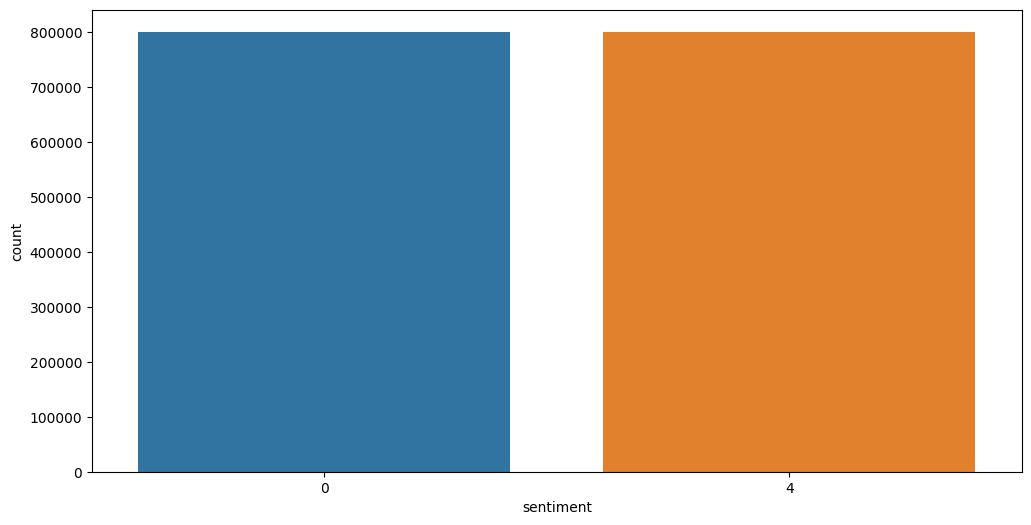

In [6]:
plt.figure(figsize = (12,6), dpi = 100)
sns.countplot(x = 'sentiment', data = df)


In [7]:
df.sentiment.value_counts()

sentiment
0    800000
4    800000
Name: count, dtype: int64

In [8]:
to_sentiment={0:'Negative',4:'Positive'}
def label_decoder(label):
    return to_sentiment[label]

df.sentiment = df.sentiment.apply(label_decoder)
df.head(10)

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."
5,Negative,@Kwesidei not the whole crew
6,Negative,Need a hug
7,Negative,@LOLTrish hey long time no see! Yes.. Rains a...
8,Negative,@Tatiana_K nope they didn't have it
9,Negative,@twittera que me muera ?


In [9]:
df.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [10]:
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
s = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
s = re.sub(text_cleaning_re, ' ', str(s).lower()).strip()
s


'awww that s a bummer you shoulda got david carr of third day to do it d'

In [11]:
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')


In [12]:
def preprocess(text, stem = False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for word in text.split():
        if word not in stop_words:
            if stem:
                tokens.append(stemmer.stem(word))
            else:
                tokens.append(word)
                
    return ' '.join(tokens)
    

In [13]:
s = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
preprocess(s)

'awww bummer shoulda got david carr third day'

In [14]:
df.text = df.text.apply(preprocess)
df.head(10)

,sentiment,text
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset update facebook texting might cry result...
2,Negative,dived many times ball managed save 50 rest go ...
3,Negative,whole body feels itchy like fire
4,Negative,behaving mad see
5,Negative,whole crew
6,Negative,need hug
7,Negative,hey long time see yes rains bit bit lol fine t...
8,Negative,nope
9,Negative,que muera


In [15]:
train_data, test_data = train_test_split(df, test_size = 0.2, random_state = 5)
print('Size of the training data : ', len(train_data))
print('Size of the testing data  : ', len(test_data))

Size of the training data :  1280000
Size of the testing data  :  320000


In [16]:
MAX_NB_WORDS = 10000
MAX_SEQ_LENGTH = 30

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)


In [18]:
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('vocab size : ', vocab_size)

vocab size :  290739


In [19]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = MAX_SEQ_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen = MAX_SEQ_LENGTH) 

In [20]:
print(x_train.shape, x_test.shape)

(1280000, 30) (320000, 30)


In [21]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.tolist())
y_test  = encoder.transform(test_data.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test  = y_test.reshape(-1,1)

In [22]:
print('Training labels shape : ', y_train.shape)
print('Testing labels shape : ', y_test.shape)

Training labels shape :  (1280000, 1)
Testing labels shape :  (320000, 1)


In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-06-15 04:22:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-06-15 04:22:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-06-15 04:22:25--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [24]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'

In [25]:
embeddings_index = {}
f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float')
    embeddings_index[word]=coefs
    
f.close()

In [26]:
print(len(embeddings_index))

400000


In [27]:
EMBEDDING_DIM = 300

In [28]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word,token in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[token] = embedding_vector


In [29]:
embedding_matrix.shape

(290739, 300)

In [31]:
embedding_layer = Embedding(vocab_size,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQ_LENGTH,
                           trainable = False)

In [39]:
x = SpatialDropout1D(0.2)(embedding_seq)

sequence_input = Input(shape = (MAX_SEQ_LENGTH,), dtype = 'int32')
embedding_seq = embedding_layer(sequence_input)

x = Conv1D(64, 5, activation = 'relu')(embedding_seq)
x = Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
output = Dense(1, activation = 'sigmoid')(x)

In [41]:
model = tf.keras.Model(sequence_input, output)

In [45]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 30, 300)        │    87,221,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 26, 64)         │        96,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,713,029 (334.60 MB)

 Trainable params: 491,329 (1.87 MB)

 Non-trainable params: 87,221,700 (332.72 MB)

In [46]:
LR = 0.001
BATCH_SIZE = 1024
EPOCHS = 40

In [48]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate = LR),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [49]:
history = model.fit(x_train,
                    y_train,
                    validation_data = (x_test, y_test),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS)

Epoch 1/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 49ms/step - accuracy: 0.7269 - loss: 0.5336 - val_accuracy: 0.7667 - val_loss: 0.4837
Epoch 2/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.7677 - loss: 0.4803 - val_accuracy: 0.7729 - val_loss: 0.4715
Epoch 3/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.7770 - loss: 0.4659 - val_accuracy: 0.7757 - val_loss: 0.4672
Epoch 4/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.7822 - loss: 0.4586 - val_accuracy: 0.7763 - val_loss: 0.4655
Epoch 5/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.7858 - loss: 0.4520 - val_accuracy: 0.7768 - val_loss: 0.4643
Epoch 6/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.7875 - loss: 0.4483 - val_accuracy: 0.7767 - val_loss: 0.4639
Epoch 7/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.7904 - loss: 0.4444 - val_accuracy: 0.7750 - val_loss: 0.4654
Epoch 8/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.7920 -

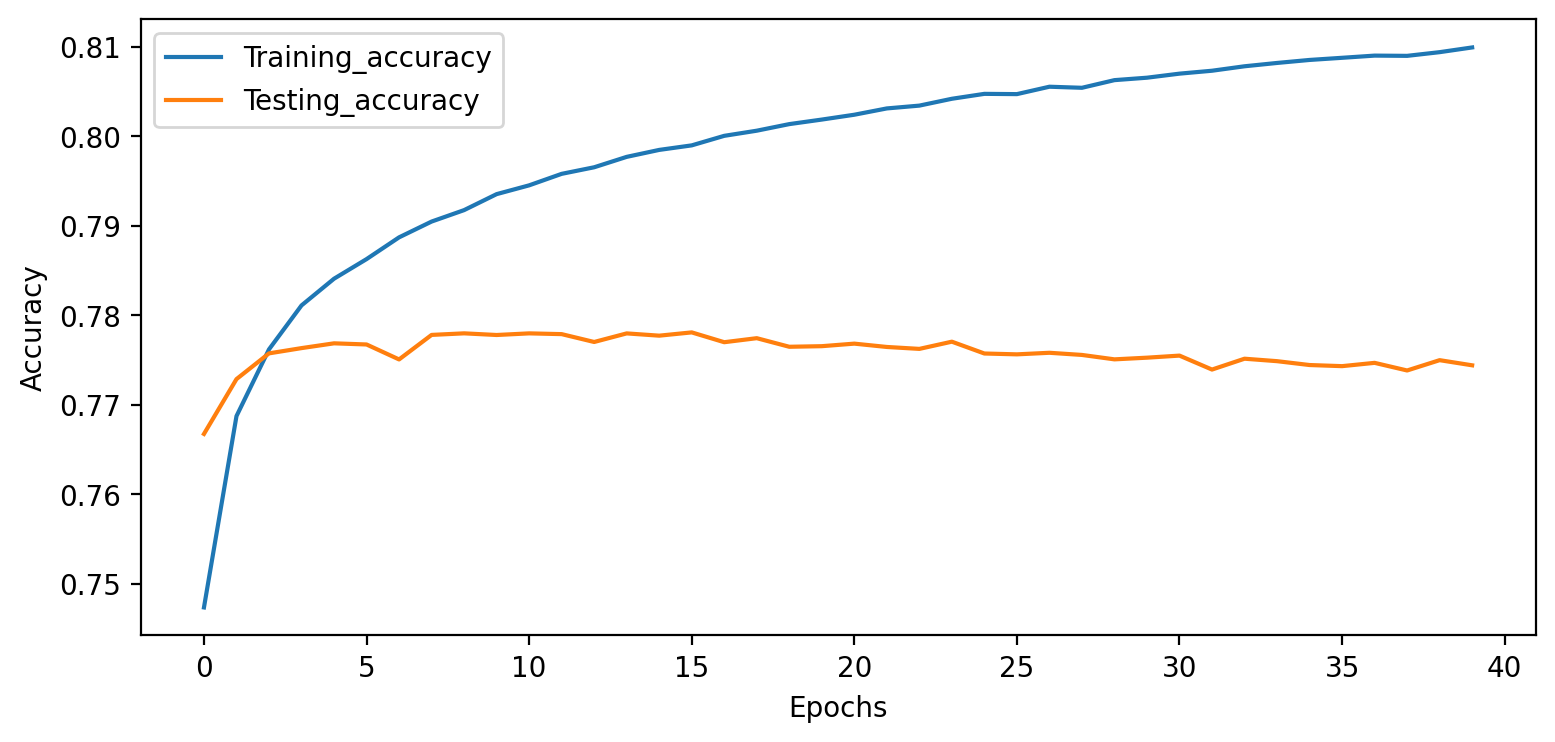

In [50]:
train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']

plt.figure(figsize = (9,4), dpi = 200)
plt.plot(train_acc, label = 'Training_accuracy')
plt.plot(val_acc, label = 'Testing_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


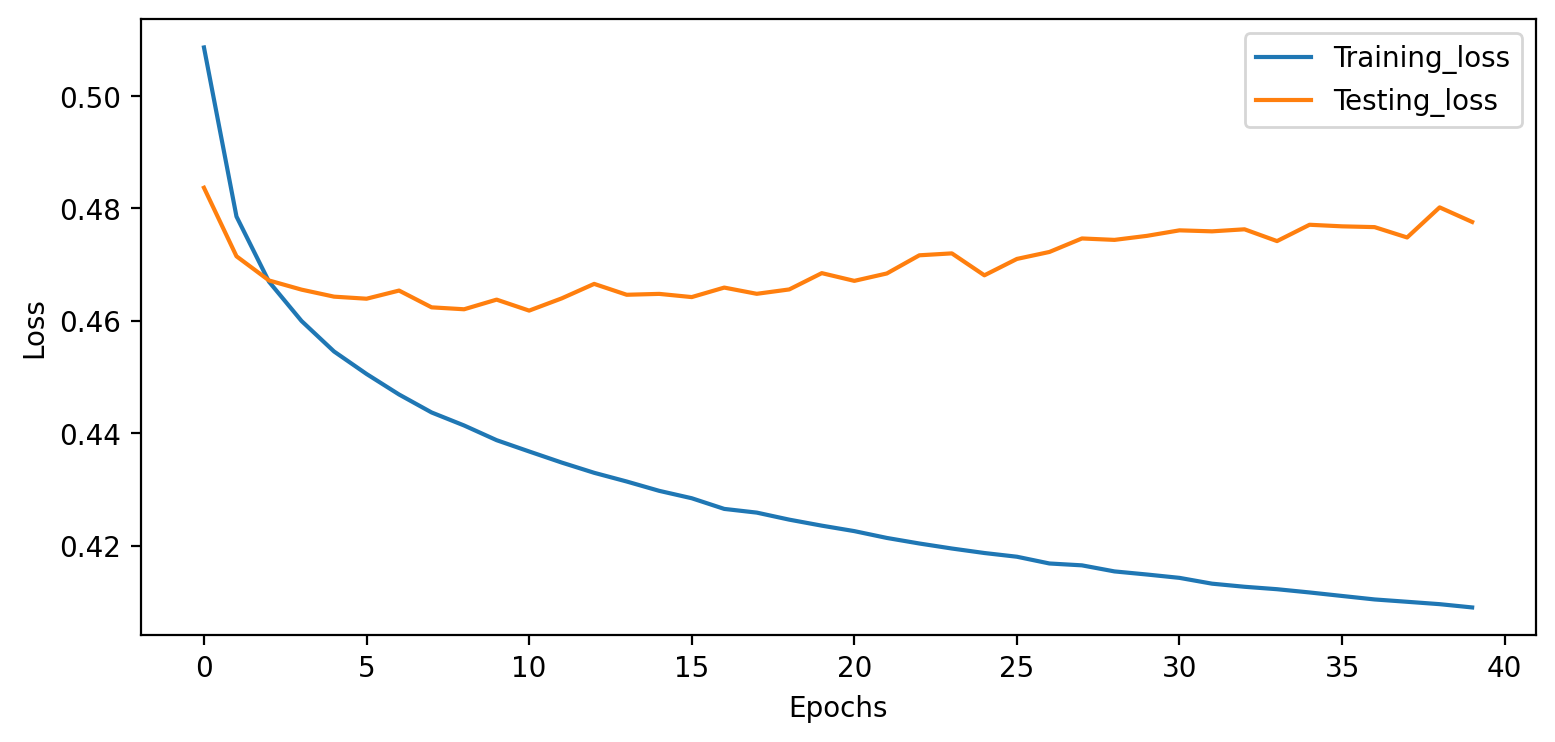

In [51]:
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

plt.figure(figsize = (9,4), dpi = 200)
plt.plot(train_loss, label = 'Training_loss')
plt.plot(val_loss, label = 'Testing_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [52]:
model.predict(x_train[0:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


array([[0.48146838],
       [0.00553343],
       [0.58826286],
       [0.51009405],
       [0.8496635 ]], dtype=float32)

In [55]:
def predict_sentiment(x):
    prob = model.predict(x)
    if prob > 0.5:
        print('Positive')
    else:
        print('Negative')

In [56]:
def predict_sentiment(x):
    probs = model.predict(x)
    for prob in probs :
        if prob > 0.5:
            print('Positive')
        else:
            print('Negative')

In [57]:
predict_sentiment(x_train[0:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Negative
Negative
Positive
Positive
Positive


In [59]:
def decode_sentiment(prob):
    return 'Positive' if prob > 0.5 else 'Negative'
probs = model.predict(x_test)
y_pred_test = [decode_sentiment(prob) for prob in probs]

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 121s 12ms/step


In [64]:
# Confusion Matrics Tempate
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = cm.astype('float')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

In [65]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(test_data.sentiment.to_list(), y_pred_test)

In [66]:
cf

array([[120871,  38918],
       [ 33276, 126935]])

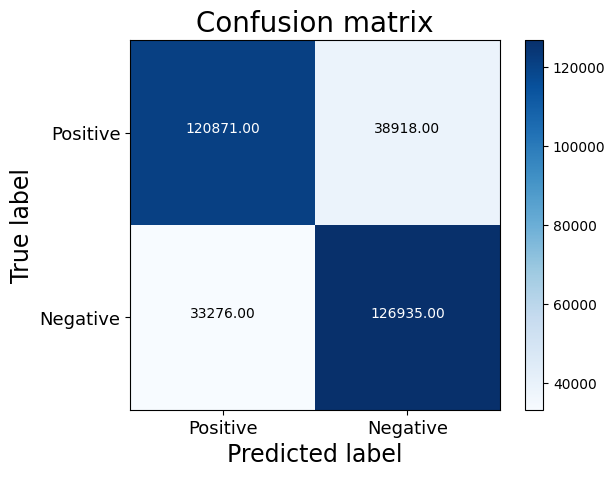

In [67]:
plt.figure()
plot_confusion_matrix(cf, classes = ['Positive', 'Negative'])
plt.show()